In [1]:
import os
from glob import glob
from PIL import Image

import cv2
import albumentations as A

os.chdir('/opt/ml/P-Stage/1-STAGE/')

In [2]:
sample_path = '/opt/ml/input/data/eval/images/0001b62fb1057a1182db2c839de232dbef0d1e90.jpg'
sample_image = cv2.imread(sample_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image.shape

(512, 384, 3)

In [3]:
pil_img = Image.open(sample_path)
pil_img.size

(384, 512)

# 사용 할 만한 augmentation 조사

함수에 따라서 적용 가능한 type이 다르다. 웬만하면 uint8 사용하셈.

## 나이 ( Age )

### 사람이라면?

> 사진만 보고 구분을 하라고 한다면 ...

1. 얼굴을 보고 예측을 하거나
2. 옷 스타일을 보고 예측을 할 것 같다.
3. 위 두가지로도 판단이 안 된다면..? 배경을 봐야 되지 않을까..?
    - 배경을 보고 예측을 하는 건 말이 안 되는 것 같다.

**여성의 나이가 평균 값이 높고 남성의 나이가 평균 값이 낮다.**

> 실제 모델에서 이러한 경향이 나타내는 지를 확인 해야한다. ( validation이나 test(?) 에서)

### 마스크를 썼다면?

1. 나이가 든 사람들이 선호하는 마스크들이 있나 체크를 해봐야하고
2. 눈가의 주름을 보거나
3. 머리카락의 길이?
    - 이것도 비약적인 가정인 것 같다.
4. 마스크의 종류나 색깔?
    - 이것도 비약적인 가정...

### 사용 기법

> 같이 Augmentation을 사용하면 안 되는 조합들이 있다. ( 내 가정으로는 )

- 얼굴을 가리는 기법 ( 옷으로 나이 예측 )
- 색깔을 바꾸는 기법 ( 주름으로 나이를 예측할 수 있도록..? ) # 바뀐 색깔에 적응할 수도 있나?
- Grid하게 위치 바꾸기 ( 모델이 스스로 얼굴과 옷을 찾을 수 있도록 )

## 마스크 ( Mask )

### 사람이라면?

> 코스크와 턱스크.. Image Resize대신 (224, 224) CenterCrop을 진행하는 것이 좋을 듯 싶다.

마스크 예측의 핵심은 Correct와 Incorrect를 구분하는 것.

1. 코가 보이면 Incorrect, 안 보이면 Correct
2. 코스크는 처음 듣는데, 이렇게 쓰는 사람이 있나?

### 사용 기법

- CenterCrop(224, 224)
- Inverted 써보자, 색깔에 상관없이 마스크만 값을 가져올 수 있도록.. 근데 그게 가능하나? RGB값이 바뀌는데
- 마스크를 가리는 것은 하지 말자.
- Grid하게 위치 바꾸기 ( 중앙이 중요한 것이 아니라 마스크가 중요하다는 것을 알려주기 )
- Grid하게 위치 바꾸기 ( 더 잘게 나눌 수 있으면 더 잘게 나눠보자 )

## 성별 ( Gender )

### 사람이라면?

1. 얼굴 보고 ( 눈이나 머리카락 같은 것들 )
2. 어깨 크기
3. 옷 색깔 ( 이건 잘 모르겠음 )

### 사용 기법

- CutOut같은 것 Mask가 성별 예측에 영향을 끼치는 것을 업애기 위해

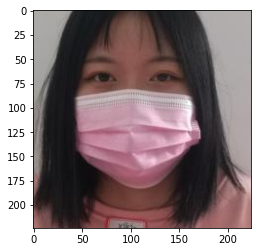

In [4]:
# Center Crop Check Shape
import matplotlib.pyplot as plt

crop_image = A.CenterCrop(224, 224, p=1)(image=sample_image)['image']
plt.imshow(crop_image)

In [5]:
crop_image.shape

(224, 224, 3)

In [6]:
sample_image = A.Resize(224, 224)(image=sample_image, mask=sample_image)['image']

In [7]:
sample_image.shape

(224, 224, 3)

In [8]:
sample_image[:,:, 0]

array([[164, 164, 165, ..., 178, 178, 178],
       [164, 164, 165, ..., 178, 178, 178],
       [164, 164, 165, ..., 178, 178, 178],
       ...,
       [166, 170, 172, ..., 197, 198, 200],
       [166, 169, 171, ..., 197, 199, 201],
       [165, 168, 170, ..., 197, 201, 204]], dtype=uint8)

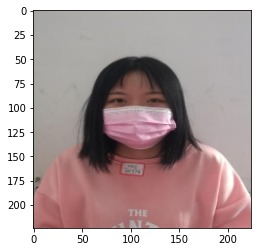

In [9]:
plt.imshow(sample_image)

In [10]:
from functools import partial

mask_dropout_fn = partial(A.MaskDropout.__call__, mask=mask)

NameError: name 'mask' is not defined

In [ ]:
A.MaskDropout.__call__ = mask_dropout_fn

In [11]:
A.MaskDropout(p=1)(image=sample_image)

AssertionError: MaskDropout requires ['mask']

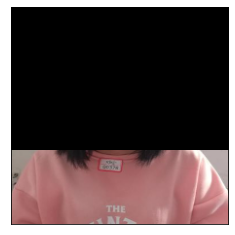

In [12]:
import numpy as np

w = 224 // 3
h = 224 // 3

mask = np.zeros_like(sample_image[:,:,0]).astype(np.uint8)
mask[:h+h,:] = np.ones_like(mask[:h+h,:]).astype(np.uint8)

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(A.MaskDropout(p=1)(image=sample_image, \
                              mask=mask)['image'])

In [13]:
mask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

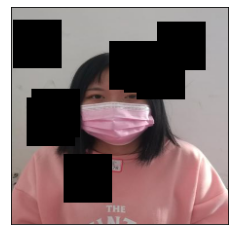

In [14]:
# 결정경계가 더 좋아지려나?
import matplotlib.pyplot as plt

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(A.CoarseDropout(max_width=50, max_height=50, p=1)(image=sample_image)['image'])

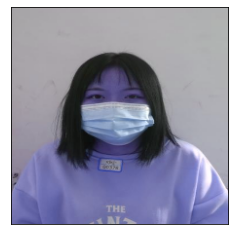

In [15]:
# ColorJitter 쓰는게 좋을 듯
trans_fn = A.ChannelShuffle(p=1) # 모델이 옷의 색깔이나, 피부 색깔로 예측하는 걸 방지.
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

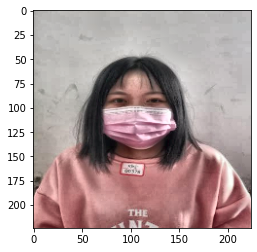

In [16]:
trans_fn = A.CLAHE(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

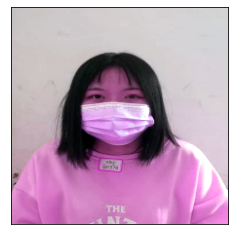

In [17]:
trans_fn = A.ColorJitter(p=1)  # 모델이 옷의 색깔이나, 피부 색깔로 예측하는 걸 방지.
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

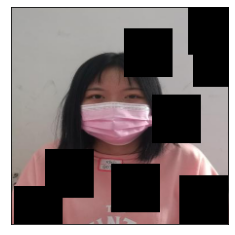

In [18]:
# 결정 경계 ?
trans_fn = A.Cutout(p=1, max_h_size=50, max_w_size=50)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

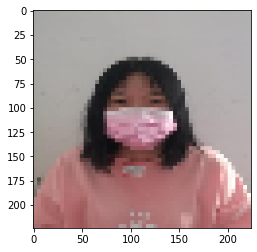

In [19]:
# 흐음... 이미지는 다 품질이 좋은데
trans_fn = A.Downscale(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

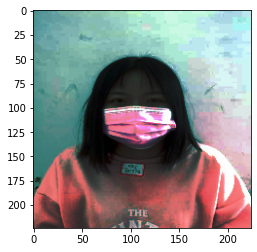

In [20]:
# 이건 아닌 듯, 마스크 구분할 때? 사용하기도 좀 그럴 듯
trans_fn = A.Equalize(p=1)  
plt.imshow(trans_fn(image=sample_image)['image'])

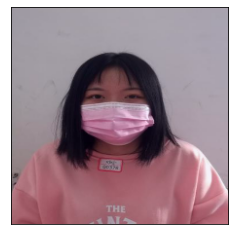

In [21]:
# 주성분 분석의 고유 값과 고유 벡터를 사용하여 이미지의 특징과 세부 사항을 유지하면서 이미지를 확대
# 사람의 피부가 바뀌는 색상의 변환이 거의 일어나지 않음.
trans_fn = A.FancyPCA(alpha=0.5, p=1) 
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

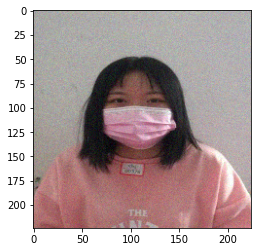

In [22]:
# 별 도움 안 될듯
trans_fn = A.GaussNoise(var_limit=(50, 100), p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

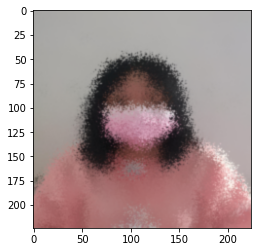

In [23]:
trans_fn = A.GlassBlur(p=1)  # 블러는 별 도움 안 될 것 같다. 마스크에서 살짝?
plt.imshow(trans_fn(image=sample_image)['image'])

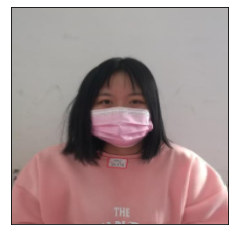

In [24]:
# 이건, 아님
trans_fn = A.GridDistortion(p=1)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

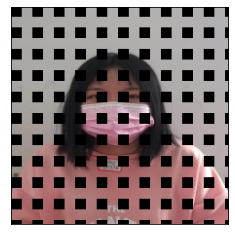

In [25]:
# 오 괜찮을 듯
trans_fn = A.GridDropout(p=1)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

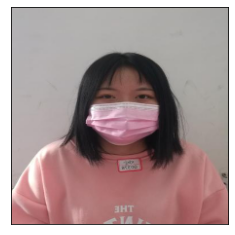

In [26]:
# 이거는 괜찮을 듯, y축이라
trans_fn = A.HorizontalFlip(p=1)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

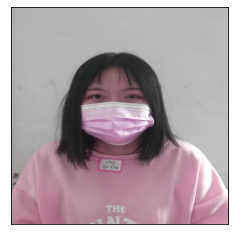

In [27]:
# 흠... 과연?
trans_fn = A.HueSaturationValue(p=1)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

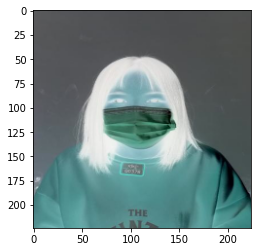

In [28]:
# 별로다.
trans_fn = A.InvertImg(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

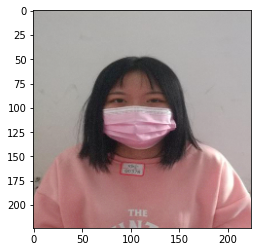

In [29]:
# 별로다2
trans_fn = A.ISONoise(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

In [30]:
# 별로다2
trans_fn = A.MaskDropout(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

AssertionError: MaskDropout requires ['mask']

In [ ]:
# 별로다3
trans_fn = A.MedianBlur(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

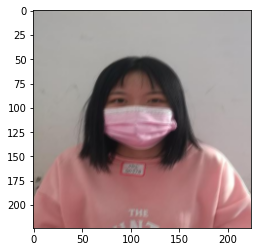

In [31]:
# 별로다4
trans_fn = A.MotionBlur(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

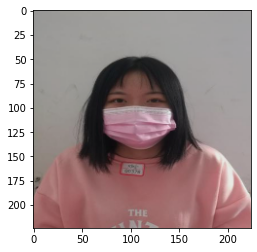

In [32]:
# 별로다5
trans_fn = A.MultiplicativeNoise(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


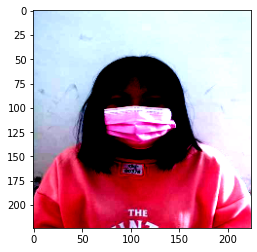

In [33]:
# 별로다5
trans_fn = A.Normalize(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

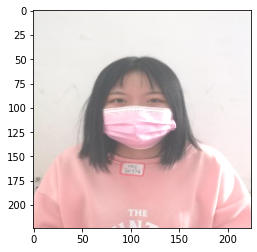

In [34]:
# 입력 이미지의 밝기를 임의로 변경
# 필요
trans_fn = A.RandomBrightness(limit=0.5, p=1)
# plt.grid(False)
# plt.xticks([])
# plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

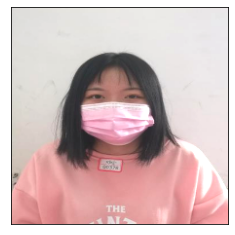

In [35]:
# 입력 이미지의 밝기와 대비 임의로 변경
trans_fn = A.RandomBrightnessContrast(p=1)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

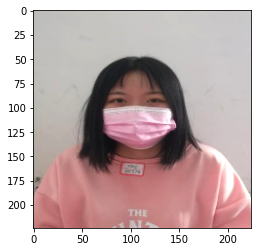

In [36]:
# 입력 이미지의 대비를 임의로 변경
# 좋은 듯
trans_fn = A.RandomContrast(limit=0.5, p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

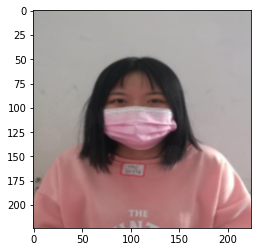

In [37]:
# 이미지의 안개를 시뮬레이션
# 필요 없을 듯
trans_fn = A.RandomFog(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

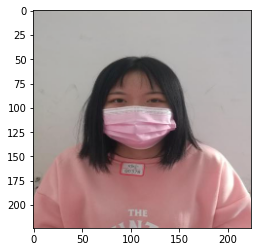

In [38]:
# 이미지의 안개를 시뮬레이션
# 필요 없을 듯
trans_fn = A.RandomGamma(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

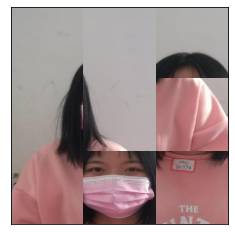

In [39]:
# 이건 잘 모르겠다, 사람은 구분이 가능한데?
trans_fn = A.RandomGridShuffle(p=1)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

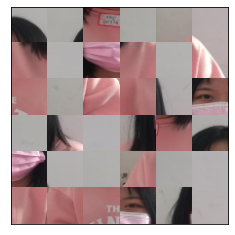

In [40]:
# 이건 잘 모르겠다, 사람은 구분이 가능한데?
trans_fn = A.RandomGridShuffle(p=1, grid=(6, 6))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

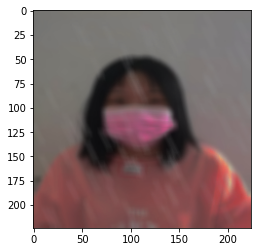

In [41]:
# 이거 아님
trans_fn = A.RandomRain(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

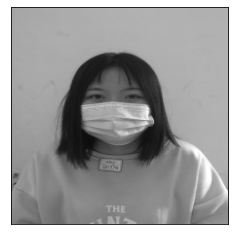

In [42]:
# 흠.. 마스크?
trans_fn = A.ToGray(p=1)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(trans_fn(image=sample_image)['image'])

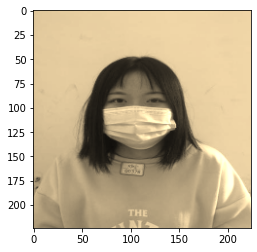

In [43]:
# 세피아 필터 적용
trans_fn = A.ToSepia(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

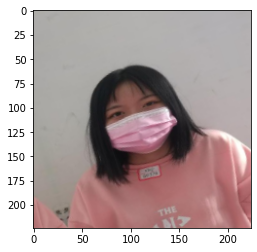

In [58]:
trans_fn = A.ShiftScaleRotate(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

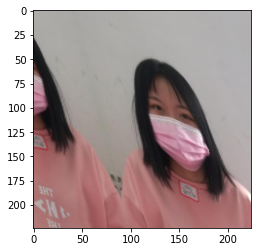

In [59]:
trans_fn = A.ElasticTransform(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

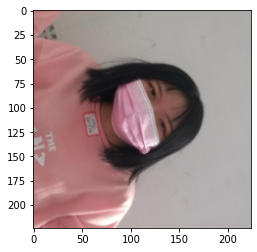

In [69]:
trans_fn = A.IAAAffine(p=1, rotate=250, shear=0.5)
plt.imshow(trans_fn(image=sample_image)['image'])

(1024, 1024, 3)


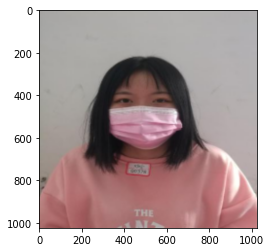

In [79]:
trans_fn = A.SmallestMaxSize(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])
print(trans_fn(image=sample_image)['image'].shape)

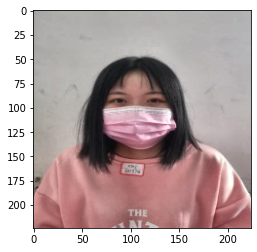

In [80]:
trans_fn = A.CLAHE(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

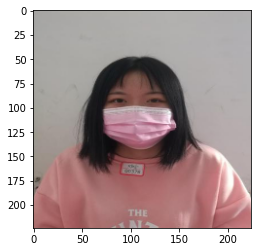

In [81]:
trans_fn = A.FancyPCA(p=1)
plt.imshow(trans_fn(image=sample_image)['image'])

In [44]:
import os
import torch

weight_path = "/opt/ml/weights"

age_path = os.path.join(weight_path, "age.pt")
mask_path = os.path.join(weight_path, "mask.pt")
gender_path = os.path.join(weight_path, "gender.pt")

age_model = torch.load(age_path)
mask_model = torch.load(mask_path)
gender_model = torch.load(gender_path)

In [45]:
trans_gray = A.ToGray(p=1)
trans_sepia = A.ToSepia(p=1)
trans_resize = A.Resize(224, 224)

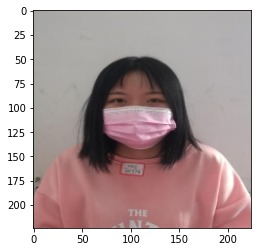

In [46]:
# pipe line 
import matplotlib.pyplot as plt

plt.imshow(sample_image)
s_image = trans_gray(image=sample_image)['image']
s_image = trans_sepia(image=s_image)['image']
s_image = trans_resize(image=s_image)['image']

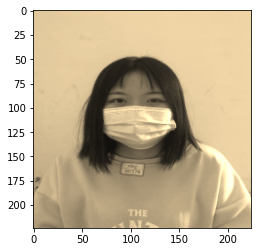

In [47]:
plt.imshow(s_image)

In [48]:
s_image.shape, s_image.transpose(2, 1, 0).shape

((224, 224, 3), (3, 224, 224))

In [49]:
s_image.transpose(2, 1, 0).reshape(1, *s_image.shape).shape

(1, 224, 224, 3)

In [50]:
s_image = s_image.transpose(2, 1, 0)
age_model(torch.tensor(s_image.reshape(1, *s_image.shape) / 255).cuda().float())

tensor([[ 0.7731, -0.7811, -0.5166]], device='cuda:0', grad_fn=<AddmmBackward>)

In [51]:
sample_images.shape

NameError: name 'sample_images' is not defined

In [63]:
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

transformed = transform(image=sample_image)
transformed_image = transformed["image"]

In [64]:
transformed_image.shape

(256, 256, 3)

## Last Check

In [302]:
import os
import time
import numpy as np
from glob import glob
from PIL import Image

import cv2
import pandas as pd
import albumentations as A
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit

from config import get_args


def get_classes(key):
    """ predict하기 위해서는 순서가 중요하다. """
    if key == "mask":
        return ["wear", "incorrect", "not wear"]
    if key == "age":
        return ["age < 30", "30 <= age < 60", "60 <= age"]
    if key == "gender":
        return ["male", "female"]
    raise KeyError("key must be in ['mask', 'age', 'gender']")


def get_transforms(args):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    transform = transforms.Compose(
        [
            transforms.Resize((args.image_size, args.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )

    return transform


def get_album_transforms(args):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    trans_fns = [
        A.CoarseDropout(max_width=50, max_height=50, p=0.5),
        A.ChannelShuffle(p=0.5),
        A.ColorJitter(p=0.5),
        A.Cutout(p=0.5, max_h_size=50, max_w_size=50),
        A.FancyPCA(alpha=0.5, p=0.5),
        A.GridDistortion(p=0.5),
        A.GridDropout(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGridShuffle(p=0.5),
        A.ToGray(p=1),  # 12
    ]

    # (결국에는) Trasnsform을 만들어서 사용하는 것이 좋다.

    trans_fn = trans_fns[args.temp_aug_index]
    transform = A.Compose(
        [
            A.Resize(args.image_size, args.image_size),
            trans_fn,  # keep uint8
            A.Normalize(mean, std),
        ]
    )

    return transform


class MaskDataSet(Dataset):
    def __init__(self, args, is_train=True, transform=None):
        csv_file = os.path.join(args.data_dir, "train.csv")
        self.datas = pd.read_csv(csv_file)
        self.images, self.labels = self._load_image_files_path(args, is_train)
        self.label_idx = ["gender", "age", "mask"].index(args.train_key)
        self.args = args

        if args.test:
            self.images, self.labels = self.images[:100], self.labels[:100]

        self.transform = transform

    def __getitem__(self, idx):

        img = Image.open(self.images[idx])
        img = np.array(img)  # time: 16.8463

        #  img = cv2.imread(self.images[idx])
        #  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # time: 25.4017

        #  if self.transform:
        #      img = self.transform(img)

        if self.transform:
            img = self.transform(image=img)["image"]

        # Share Memory
        img = np.transpose(img, axes=(2, 0, 1))  # (w, h, c) +> (c, w, h)
        #  img = album_transformation(self.args, img)

        return img, self.labels[idx][self.label_idx]

    def __len__(self):
        return len(self.images)

    def _load_image_files_path(self, args, is_train):
        split = StratifiedShuffleSplit(
            n_splits=1,
            test_size=args.valid_size,
            random_state=0,  # 이 SEED값은 안 바꾸는 것이 좋다.
        )

        split_key = "age" if args.train_key == "age" else "gender"

        for train_index, valid_index in split.split(self.datas, self.datas[split_key]):
            train_dataset = self.datas.loc[train_index]
            valid_dataset = self.datas.loc[valid_index]

        dataset = train_dataset if is_train else valid_dataset
        gender_classes = get_classes("gender")

        images = []
        labels = []

        for dir_name in dataset["path"]:
            dir_path = os.path.join(args.data_dir, "images", dir_name)

            image_id, gender_lbl, _, age_lbl = dir_name.split("_")

            gender_class = gender_classes.index(gender_lbl)

            # ["age < 30", "30 <= age < 60", "60 <= age"]
            age_lbl = int(age_lbl)

            if age_lbl < 30:
                age_class = 0
            elif age_lbl >= 60:
                age_class = 2
            else:
                age_class = 1

            for jpg_filepath in glob(dir_path + "/*"):
                jpg_basename = os.path.basename(jpg_filepath)

                if "normal" in jpg_basename:
                    mask_class = 2
                elif "incorrect" in jpg_basename:
                    mask_class = 1
                else:
                    mask_class = 0

                images.append(jpg_filepath)
                labels.append((gender_class, age_class, mask_class))

        return images, labels


def get_dataloader(args):
    transform = get_album_transforms(args)

    train_dataset = MaskDataSet(args, is_train=True, transform=transform)
    valid_dataset = MaskDataSet(args, is_train=False, transform=transform)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.workers,
        pin_memory=True,
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.workers,
        pin_memory=True,
    )

    return train_dataloader, valid_dataloader

In [303]:
args.batch_size = 64
args.temp_aug_index = 0
args.test = False
train_dataloader, valid_dataloader = get_dataloader(args)

In [304]:
images, labels = next(iter(train_dataloader))
output = age_model(images.cuda())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


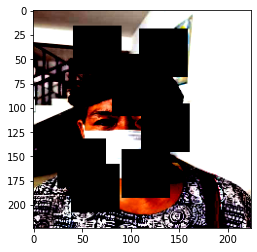

In [305]:
plt.imshow(images[0].detach().cpu().numpy().transpose(1, 2, 0))

In [297]:
s_image = get_album_transforms(args)(image=sample_image)['image']

In [298]:
s_image.shape

(224, 224, 3)

In [299]:
s_image = s_image.transpose(2, 0, 1)
print(s_image.shape)

(3, 224, 224)


In [300]:
s_image = s_image.transpose(1, 2, 0)
print(s_image.shape)

(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


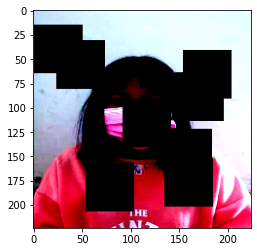

In [301]:
plt.imshow(s_image)

In [229]:
transform = A.Compose([
    A.Resize(224, 224),
    A.CoarseDropout(p=0.5, max_width=50, max_height=50)
])

In [230]:
s_image = transform(image=sample_image)['image']

In [231]:
s_image.shape

(224, 224, 3)

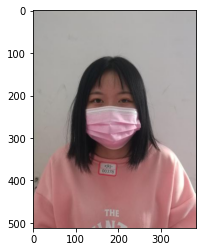

In [232]:
plt.imshow(sample_image)

In [237]:
for image, lables in train_dataloader:
    
#     image = A.resize(image, 224, 224)
#     image = A.CoarseDropout()(image=image)['image']
    print(image.shape, end='\r')

In [172]:
transforms

<module 'torchvision.transforms' from '/opt/conda/lib/python3.7/site-packages/torchvision/transforms/__init__.py'>

In [74]:
"1".split(",")

['1']